# <올리스트 데이터 분석 전처리 - orders (주문데이터) 분석>

dataset : olist_orders_dataset.csv 
- orders 항목 분석 
예상되는 분석내용
- 가장 많이 구매가 발생한 월 / 일 / 시 / 요일 
- 구매에서 배송까지 평균 얼마나 걸리는지? 
- 구매일자와 승인일자사이의 갭 살펴보기
- 배송은 시작했는데 완료일자가 없네? 오배송율? 측정

## 라이브러리 로드

In [1]:
# 핑크색 warning 안내문 방지 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 분석에 사용할 라이브러리를 불러옵니다
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## 폰트 로드

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(Colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

## 데이터로드

In [4]:
import glob

In [5]:
path = glob.glob('data/*.csv')
path

['data\\olist_customers_dataset.csv',
 'data\\olist_geolocation_dataset.csv',
 'data\\olist_orders_dataset.csv',
 'data\\olist_order_items_dataset.csv',
 'data\\olist_order_payments_dataset.csv',
 'data\\olist_order_reviews_dataset.csv',
 'data\\olist_products_dataset.csv',
 'data\\olist_sellers_dataset.csv',
 'data\\product_category_name_translation.csv']

In [6]:
# 주문 정보를 od라는 데이터프레임에 담을것 
order = pd.read_csv(path[2])

## 데이터 미리보기 및 요약

In [7]:
order.shape
# 99441개의 인덱스(행)과 8개의 컬럼(열)이 있다는 뜻

(99441, 8)

In [8]:
order.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

각 컬럼들 정보 

- order_id : 주문번호 
- customer_id : 고객번호 - 근데 요거 path[0] 보면 customer_id는 구매시마다 새로 생기는 id임. customer_unique_id가 진짜 고객 번호

                즉, order 테이블에서는 어떤 고객이 뭘 샀는지는 알 수 없지만 시계열데이터를 알아볼 수 있음 
- order_status : 주문상태
- order_purchase_timestamp : 주문일자 
- order_approved_at : 지불승인일자 (금융사 카드결제/ 통장입금확인되어 주문이 매출로 잡히는 시간 같음)
- order_delivered_carrier_date : 물류팀에 인도된 일자 (송장 나온날짜 같음)
- order_delivered_customer_date  : 배송완료일자(수령일자)
- order_estimated_delivery_date : 예상배송완료일자

In [9]:
# 상단 5개 데이터 
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
# 하단 5개 데이터 
order.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


## 데이터 타입, 기술통계값 확인

In [11]:
# order컬럼별 데이터 성격 . 
# 일단 다 object
# 시계열데이터는 pd.to_datetimed으로 데이터 타입 날짜로 바꿔주고 년/월/일 분리시 dt.year/month 요걸로 컬럼 나눠주기 
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [12]:
# 시계열데이터 object -> datetime 으로 dtype 변경
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
order['order_delivered_carrier_date'] = pd.to_datetime(order['order_delivered_carrier_date'])
order['order_delivered_customer_date'] = pd.to_datetime(order['order_delivered_customer_date'])
order['order_estimated_delivery_date'] = pd.to_datetime(order['order_estimated_delivery_date'])
order['order_approved_at'] = pd.to_datetime(od['order_approved_at'])
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


## 결측치확인

In [13]:
# null 값이 보이는데 한번 볼까? 
#  4   order_approved_at              99281 non-null  object       
#  5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
#  6   order_delivered_customer_date  96476 non-null  datetime64[ns]

# null 값이 몇개지?
order.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
order.isna().mean()*100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

### 결측치 시각화 

<AxesSubplot:>

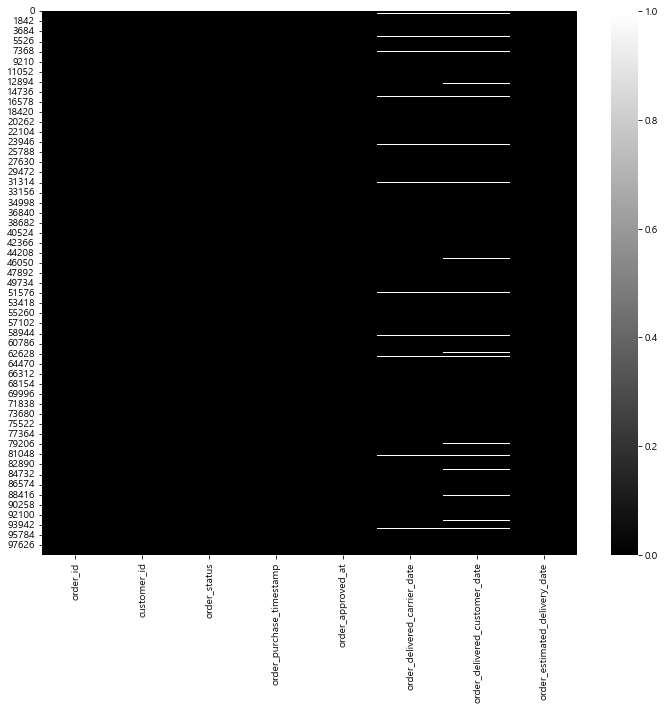

In [15]:
plt.figure(figsize = (12,10))
plt.xticks(rotation = 90)
sns.heatmap(order.isna(), cmap = 'gray')

### order_approved_at의 null 값이 160 이라는건 160개의 주문은 지불처리가 안되었다는 말
-> 즉 유효한 주문이 아니라서 데이터 분석 할 때 제외해야 함 

In [16]:
# 위의 주장을 증명해볼까?
# 'order_status' 주문 상태 컬럼에는 아래와 같은 고유값이 있음 
od['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [17]:
# 지불이 안되었다면 order_status' 데이터는 canceled가 되어야 함. 
od_canceled = od.loc[od['order_approved_at'].isnull(), ['order_purchase_timestamp' ,'order_approved_at', 'order_status','order_delivered_carrier_date','order_delivered_customer_date']  ]
od_canceled 
# 'order_approved_at' 지불처리가 안되었으니(NaT) 'order_status' 데이터는 canceled가 되는게 맞음 . 
#  다음에 오는 컬럼들(주문s,배송관련 일자정보)도 싹 다 NAT 뜨는것)
#  60 rows  - 160개 NULL 맞음 

,order_purchase_timestamp,order_approved_at,order_status,order_delivered_carrier_date,order_delivered_customer_date
1130,2018-08-28 15:26:39,NaT,canceled,NaT,NaT
1801,2018-09-20 13:54:16,NaT,canceled,NaT,NaT
1868,2017-03-04 12:14:30,NaT,canceled,NaT,NaT
2029,2018-08-29 16:27:49,NaT,canceled,NaT,NaT
2161,2017-05-01 16:12:39,NaT,canceled,NaT,NaT
...,...,...,...,...,...
97696,2017-07-02 15:38:46,NaT,canceled,NaT,NaT
98415,2017-09-28 15:02:56,NaT,canceled,NaT,NaT
98909,2018-08-07 11:16:28,NaT,canceled,NaT,NaT
99283,2018-08-31 16:13:44,NaT,canceled,NaT,NaT


In [18]:
# null 값 평균의 퍼센테이지
od.isna().mean() * 100
# 입금 안되서 주문이 취소되는 비율은 1.6% 정도 

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

### 유효한(지불이 이루어진) 주문만 데이터로 사용하자 , od_vaild

In [19]:
od_valid = od.loc[od['order_approved_at'].notnull()]
od_valid.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
75955,f1ed33d69dfbfab124dde0a2e8b129ec,ef2013fbc3141965a337692054d4fbd2,delivered,2018-04-30 10:44:34,2018-05-01 05:14:00,2018-05-03 07:30:00,2018-05-14 19:22:30,2018-05-23
68598,7a7375f58149053d599aae579288fd96,de7a087330a6bb7fe20d36390a5c2574,delivered,2018-04-27 18:13:27,2018-04-27 18:32:08,2018-05-03 14:47:00,2018-05-23 18:21:49,2018-05-16
96943,cc5a9c86cbb61d7baebfde35e243a2a9,e71484466cc8ae37af628b0035621ada,delivered,2017-11-14 20:59:52,2017-11-14 21:15:21,2017-11-17 16:21:38,2017-11-28 01:47:29,2017-12-05
64368,b7592da1b6c34d2b2404a7b6e8639376,99383db9c2af4cb2ad7503ec2f552c42,delivered,2018-08-05 21:58:38,2018-08-05 22:10:17,2018-08-07 15:42:00,2018-08-14 00:16:33,2018-08-15
80422,adbac4b12d94ba3f3e7c47dfe548fc81,1fd2567f42ea6e7de4f9772c09f1637f,delivered,2017-09-15 12:14:10,2017-09-15 12:35:09,2017-09-19 20:44:53,2017-09-22 16:57:27,2017-09-27


### 시계열데이터만 분석할 거니까 datetime 형태의 컬럼들만 새로운 데이터프레임으로 묶자

In [20]:
# 슬라이싱으로 p_time이라는 새로운 데이터 프레임으로 시계열 데이터들만 가져옴
p_time = od_valid.iloc[:, -5: ]
p_time

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...
99436,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


# #분석 1. 가장 많은 주문이 발생한 년 / 월 / 일 / 시 / 요일

구매의 기준을 지불이 이루어 진 ( od['order_approved_at']  is notnull )상태(구매의사가 있다)로 가정하고 분석을 진행하였다. 

이 부분은 분석하는 사람마다 견해가 다를 수 있다고 생각한다. 

In [21]:
# 년/월/일/시/요일 추출은 두가지 방법으로 진행할 수 있다 
# 1. p_time['order_purchase_timestamp'].astype(str).str[:4] -> 문자열슬라이싱을 이용
# 2. p_time['order_purchase_timestamp'].dt.year -> 라이브러리를 이용

In [22]:
p_time['order_year'] = p_time['order_purchase_timestamp'].dt.year
p_time['order_month'] = p_time['order_purchase_timestamp'].dt.month
p_time['order_ym'] = p_time['order_purchase_timestamp'].astype(str).str[:7] 
p_time['order_day'] = p_time['order_purchase_timestamp'].dt.day
p_time['order_dow'] = p_time['order_purchase_timestamp'].dt.dayofweek
p_time['order_hour'] = p_time['order_purchase_timestamp'].dt.hour

In [23]:
# p_time['order_ym'] = p_time['order_purchase_timestamp'].astype(str).str[:7] 
# 연-월 추출은 문자열 슬라이싱으로 진행

In [24]:
# 추출이 잘 되었는지 확인
p_time.iloc[:, -6 :]

,order_year,order_month,order_ym,order_day,order_dow,order_hour
0,2017,10,2017-10,2,0,10
1,2018,7,2018-07,24,1,20
2,2018,8,2018-08,8,2,8
3,2017,11,2017-11,18,5,19
4,2018,2,2018-02,13,1,21
...,...,...,...,...,...,...
99436,2017,3,2017-03,9,3,9
99437,2018,2,2018-02,6,1,12
99438,2017,8,2017-08,27,6,14
99439,2018,1,2018-01,8,0,21


In [25]:
#  od_vaild['order_dow'] 는 요일이 아니라 숫자로 표기 되어있으니 이걸 '월 ~ 일' 로 바꿔주자 
#  이 작업은 시간 - 요일별 빈도수 세부 분석 시 리스트 컴프리헨션으로 문자열을 리스트로 변환한 후 컬럼명 대체도 가능

p_time['order_dow'].unique()
# 다행히 주문이 없는 요일은 없음 ^^

array([0, 1, 2, 5, 6, 3, 4], dtype=int64)

In [26]:
# # astype(str).replace를 이용해 숫자로된 요일을 단어로 바꿔주자 
# p_time['order_dow'] = od_vaild['order_dow'].astype(str).replace({'0':'월', 
#                                                                   '1':'화',
#                                                                   '2':'수',
#                                                                   '3':'목',
#                                                                   '4':'금',
#                                                                   '5':'토',
#                                                                   '6':'일'})
# p_time.iloc[:, -6 :]   #요일 변환 잘 되었는지 확인 필수 

In [27]:
# 이제 order_id 별로 년/월/일/요일/시간 별 주문 건수를 분석해보자 
p_time.sample(3)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,order_ym,order_day,order_dow,order_hour
2484,2018-06-24 22:14:32,2018-06-24 22:38:21,2018-06-26 15:16:00,2018-06-28 17:22:09,2018-07-19,2018,6,2018-06,24,6,22
3057,2018-04-10 10:53:00,2018-04-11 05:50:42,2018-04-11 19:22:28,2018-04-24 15:37:12,2018-05-17,2018,4,2018-04,10,1,10
42859,2018-02-20 16:15:57,2018-02-22 02:08:52,2018-02-28 02:47:34,2018-03-05 20:33:18,2018-03-12,2018,2,2018-02,20,1,16


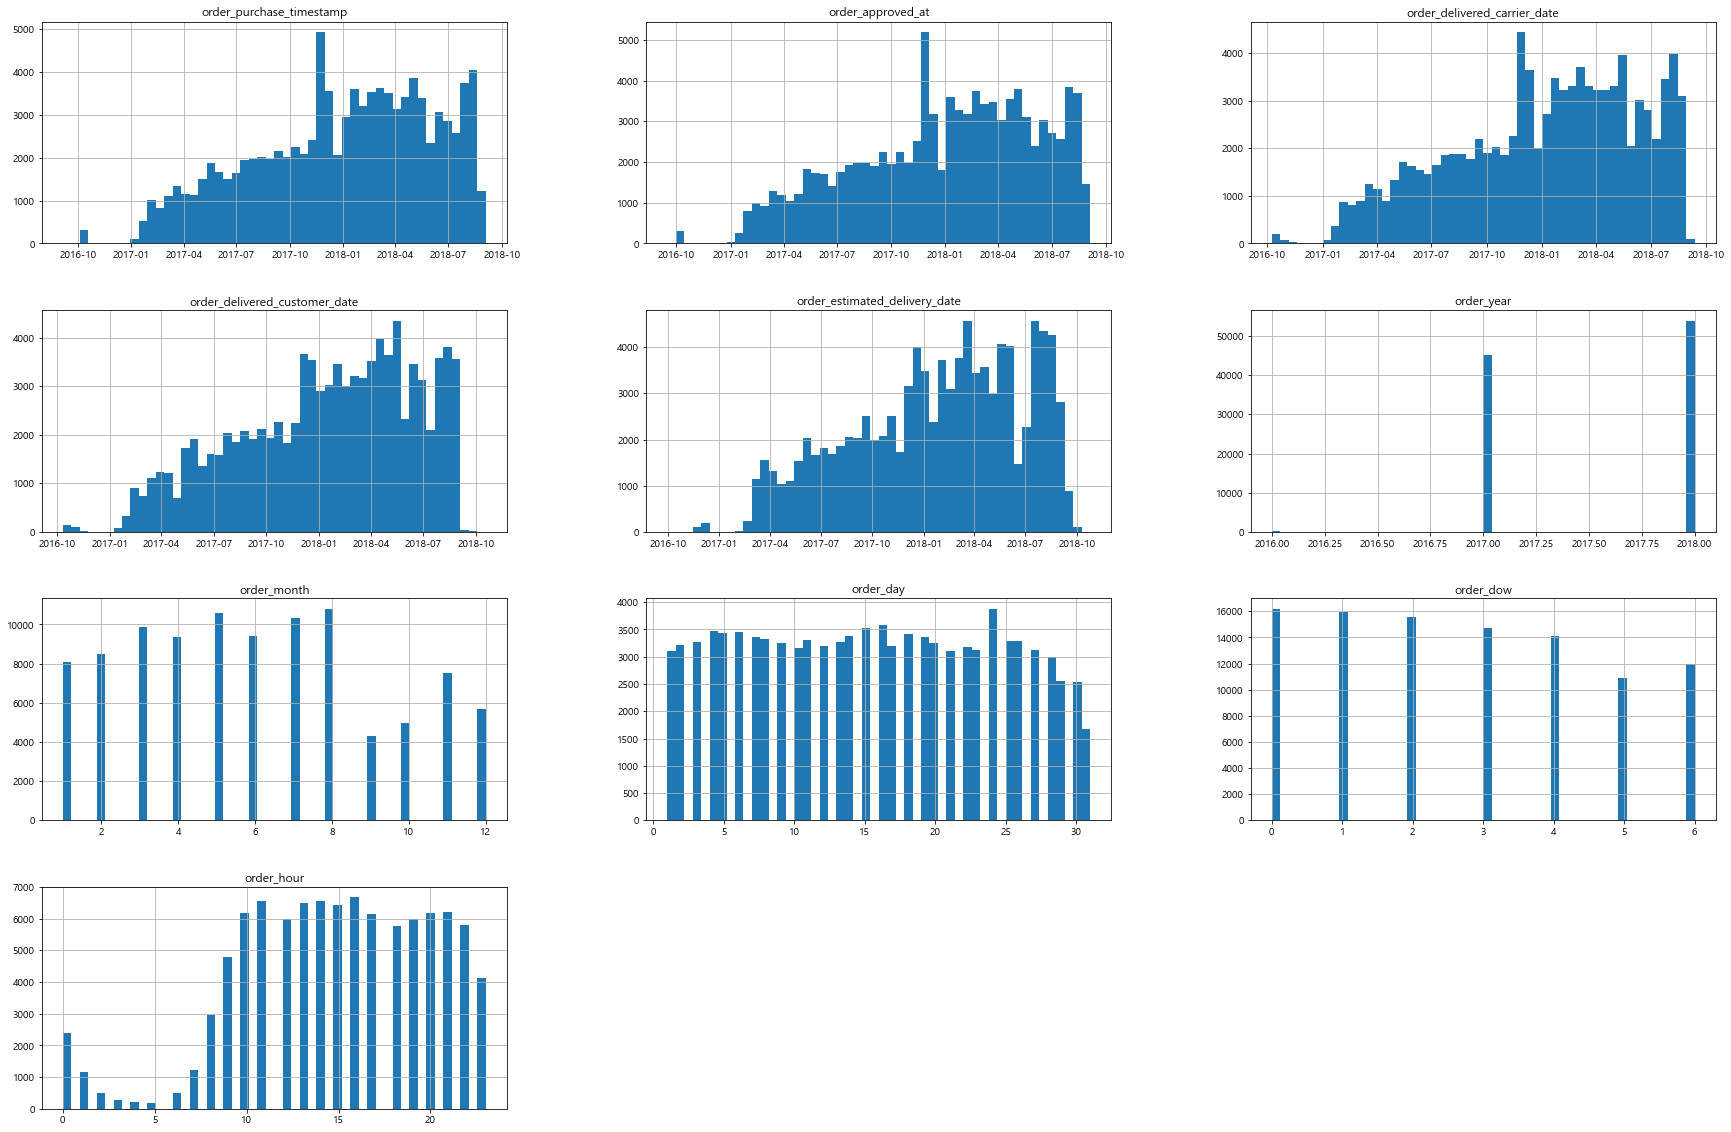

In [28]:
# 개별 분석에 앞서 히스토그램으로 전체 데이터 한번 짚고 가기 
_ = p_time.hist(figsize = (30,20), bins = 50)

## 연도별 주문건수 분석

In [29]:
# 연도별 주문건수 
# 추론 할 수 있는 사실 
# 1. olist는 2016년에 서비스를 시작했다. 
# 2. 주문량이 2017년에 대폭 상승했는데 온라인결제가 가능해졌나? 라고 추측해볼 수 있음
# 3. 2018년도 전년대비 주문량 증가 
p_time['order_year'].value_counts()

2018    53929
2017    45029
2016      323
Name: order_year, dtype: int64

<AxesSubplot:xlabel='order_year', ylabel='count'>

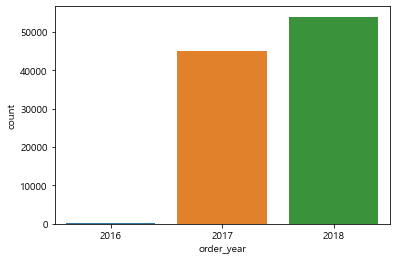

In [30]:
# 연도별 주문건수 시각화
sns.countplot(data = p_time, x = 'order_year')

## 연도-월별 주문건수 분석

In [31]:
# 세부 분석에 앞서 연도-월 로 value값을 sorting해 그래프 예쁘게 나오도록 정리
p_time = p_time.sort_values('order_ym')

In [32]:
p_time['order_ym'].value_counts()

2017-11    7535
2018-01    7268
2018-03    7208
2018-04    6939
2018-05    6872
2018-02    6724
2018-08    6459
2018-07    6291
2018-06    6167
2017-12    5666
2017-10    4626
2017-08    4325
2017-09    4281
2017-07    4021
2017-05    3691
2017-06    3241
2017-03    2680
2017-04    2400
2017-02    1766
2017-01     797
2016-10     318
2016-09       4
2016-12       1
2018-09       1
Name: order_ym, dtype: int64

<AxesSubplot:xlabel='order_ym', ylabel='count'>

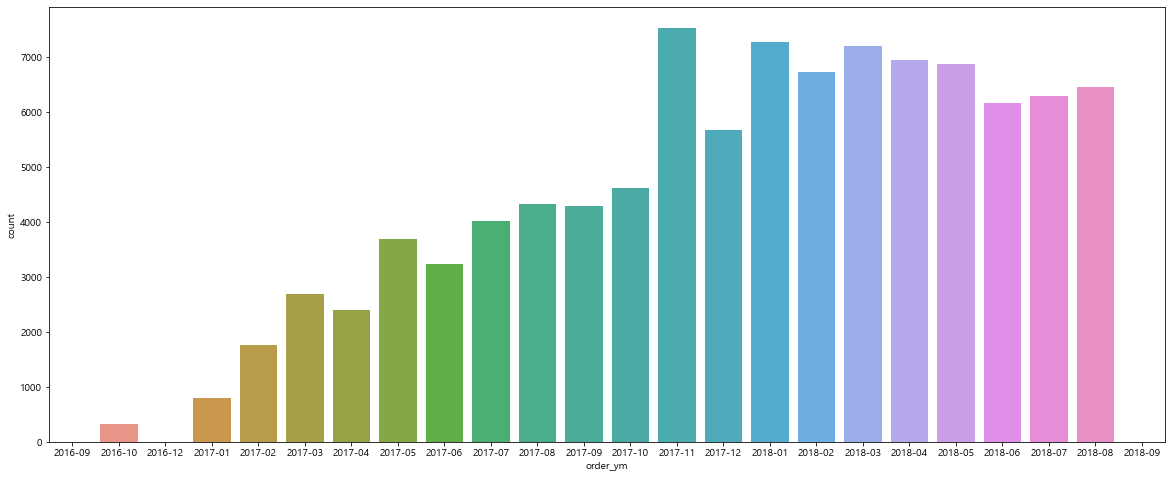

In [33]:
plt.figure(figsize = (20,8))
sns.countplot(data = p_time, x = 'order_ym')
# 2018-09월의 높이가 낮은 이유 ->  데이터가 1개 뿐임 

## 월별 주문건수 분석

In [34]:
p_time['order_month'].value_counts()

8     10784
5     10563
7     10312
3      9888
6      9408
4      9339
2      8490
1      8065
11     7535
12     5667
10     4944
9      4286
Name: order_month, dtype: int64

<AxesSubplot:xlabel='order_month', ylabel='count'>

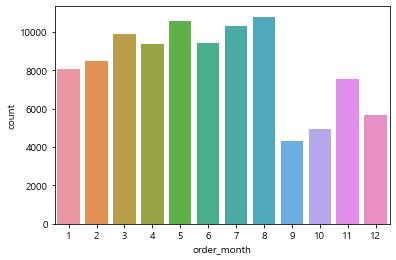

In [35]:
sns.countplot(data = p_time, x = 'order_month')
# 2016~2018년 통틀어 2분기 (4월~6월)의 주문량이 제일 높음 
# 왜 9월~12월은 주문량이 부진할까? - 이시기에는 중남미에 날씨랑 관련한 자연재해가 있나? 

## 일별 주문건수 분석

In [36]:
p_time['order_day'].value_counts()

24    3875
16    3576
15    3521
4     3481
6     3460
5     3439
18    3418
14    3385
19    3361
7     3357
8     3324
11    3307
26    3287
25    3286
3     3274
13    3270
9     3261
20    3251
2     3209
12    3199
17    3191
22    3178
10    3161
23    3123
27    3118
21    3112
1     3097
28    3002
29    2551
30    2529
31    1678
Name: order_day, dtype: int64

<AxesSubplot:xlabel='order_day', ylabel='count'>

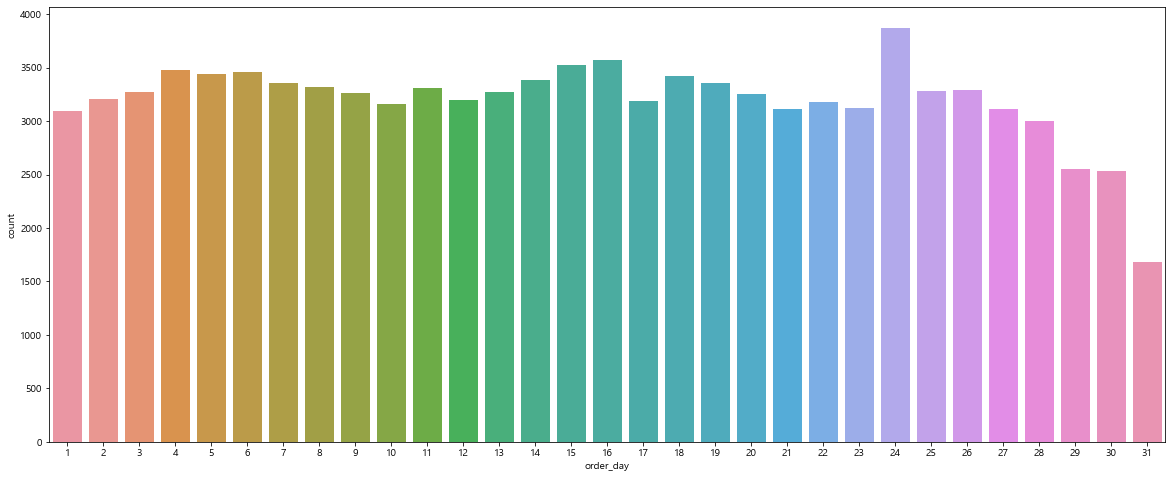

In [37]:
plt.figure(figsize = (20,8))
sns.countplot(data = p_time, x = 'order_day')
# 24일이 제일 주문이 많네 월급날임? 아니면 다음달 대비해 일주일 전 미리 무언갈 주문하는건가?

## 시간-요일별 주문건수 분석

In [38]:
# 모든 컬럼 나오게 조정 
pd.options.display.max_columns = None

In [39]:
order_hour_dow = pd.crosstab(p_time['order_hour'], p_time['order_dow'])
order_hour_dow

order_dow,0,1,2,3,4,5,6
order_hour,,,,,,,
0,328,306,397,355,425,315,267
1,134,156,179,167,213,174,140
2,66,80,81,75,72,67,69
3,36,28,33,39,49,43,44
4,21,29,33,31,40,25,27
5,22,24,27,28,36,24,27
6,69,71,93,85,97,53,34
7,160,222,211,220,206,106,105
8,479,519,514,501,493,248,205


In [40]:
# od_vaild['order_dow'] 컬럼명이 숫자 -> 리스트컴프리헨션으로 요일로 변경해주기 
dow = [요일 for 요일 in '월화수목금토일']
dow

['월', '화', '수', '목', '금', '토', '일']

In [41]:
order_hour_dow.columns = dow

In [42]:
# 변경된 것 확인
order_hour_dow

,월,화,수,목,금,토,일
order_hour,,,,,,,
0,328,306,397,355,425,315,267
1,134,156,179,167,213,174,140
2,66,80,81,75,72,67,69
3,36,28,33,39,49,43,44
4,21,29,33,31,40,25,27
5,22,24,27,28,36,24,27
6,69,71,93,85,97,53,34
7,160,222,211,220,206,106,105
8,479,519,514,501,493,248,205


<AxesSubplot:xlabel='order_dow', ylabel='count'>

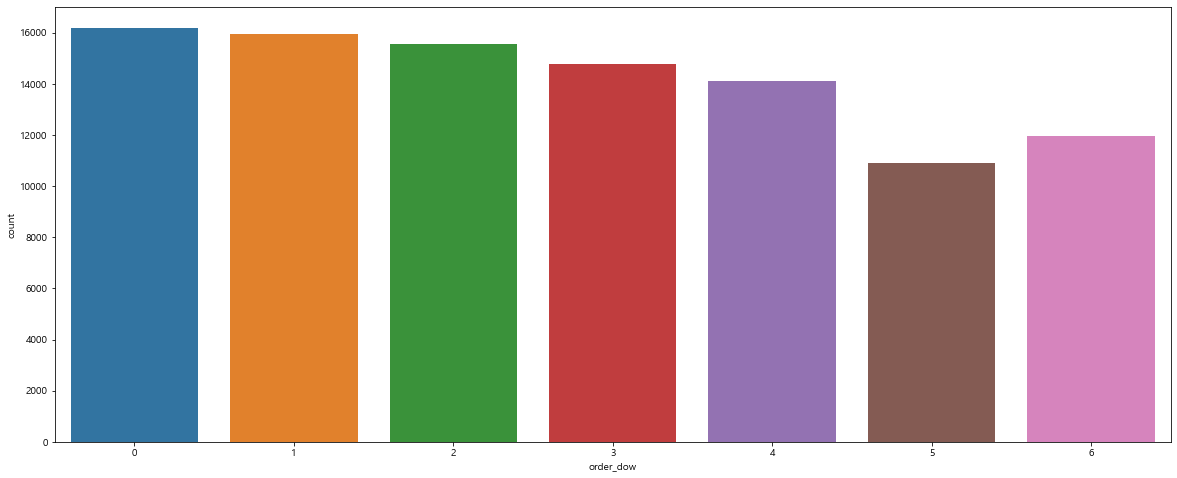

In [78]:
# 요일별 주문건수 

plt.figure(figsize = (20,8))
sns.countplot(data = p_time, x = 'order_dow')


In [90]:
p_time = p_time.astype({'order_dow' : 'str'})

In [91]:
p_time['order_dow'] = p_time['order_dow'].str.replace('0','월')
p_time['order_dow'] = p_time['order_dow'].str.replace( '1','화')
p_time['order_dow'] = p_time['order_dow'].str.replace( '2','수')
p_time['order_dow'] = p_time['order_dow'].str.replace('3','목')
p_time['order_dow'] = p_time['order_dow'].str.replace( '4','금')
p_time['order_dow'] = p_time['order_dow'].str.replace('5','토')
p_time['order_dow'] = p_time['order_dow'].str.replace('6' ,'일')

In [93]:
p_time['order_dow'].sort_values()

32818    금
38491    금
16045    금
6476     금
58668    금
        ..
53598    화
59204    화
4022     화
43538    화
10071    화
Name: order_dow, Length: 99441, dtype: object

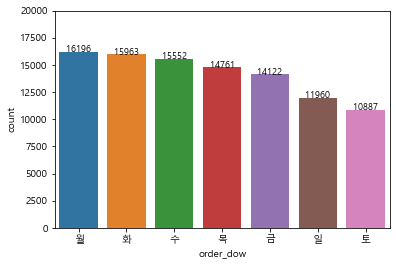

In [100]:
ax = sns.countplot(x = 'order_dow', data = p_time,
                  order = p_time['order_dow'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
ax.set_ylim(-5, 20000)
plt.show()


<AxesSubplot:xlabel='order_dow', ylabel='count'>

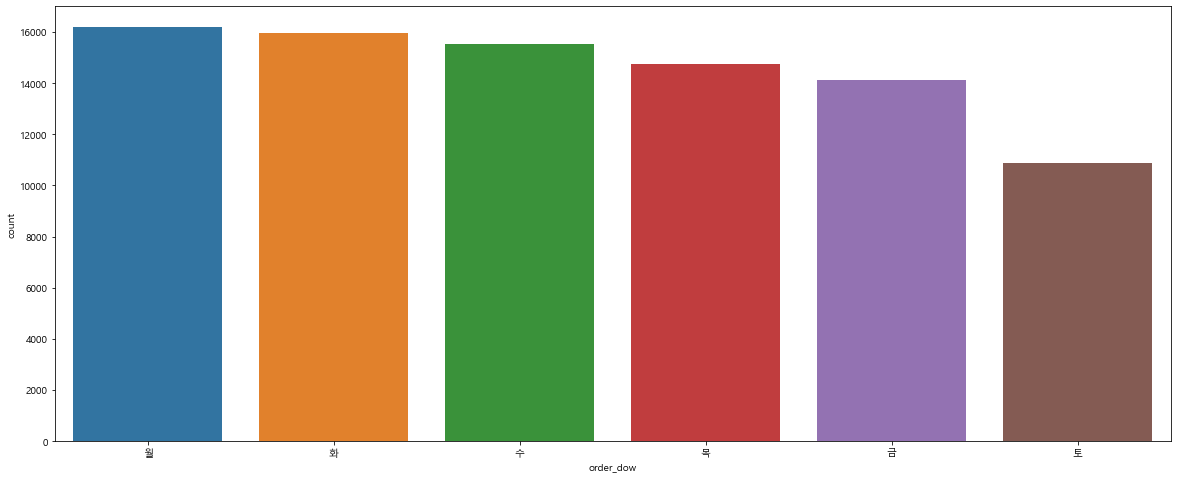

In [97]:
# 요일별 주문건수 

plt.figure(figsize = (20,8))
sns.countplot(data = p_time, x = 'order_dow', order = ['월', '화', '수','목' ,'금', '토']) 



### 시간-요일별 주문건수 시각화 1

In [43]:
# 그라디언트로 표현해보기 
order_hour_dow.style.background_gradient()

,월,화,수,목,금,토,일
order_hour,,,,,,,
0,328,306,397,355,425,315,267
1,134,156,179,167,213,174,140
2,66,80,81,75,72,67,69
3,36,28,33,39,49,43,44
4,21,29,33,31,40,25,27
5,22,24,27,28,36,24,27
6,69,71,93,85,97,53,34
7,160,222,211,220,206,106,105
8,479,519,514,501,493,248,205


In [44]:
# # 그라디언트가 표현하는 색의 의미는 컬럼 별임 ㅠ 
# 월요일 21시가 월요일 중에서 제일 색이 짙음. 
# 전체 컬럼(월~일)로 농도가 배치된게 아님 !  

### 시간-요일별 주문건수 시각화 2

<AxesSubplot:ylabel='order_hour'>

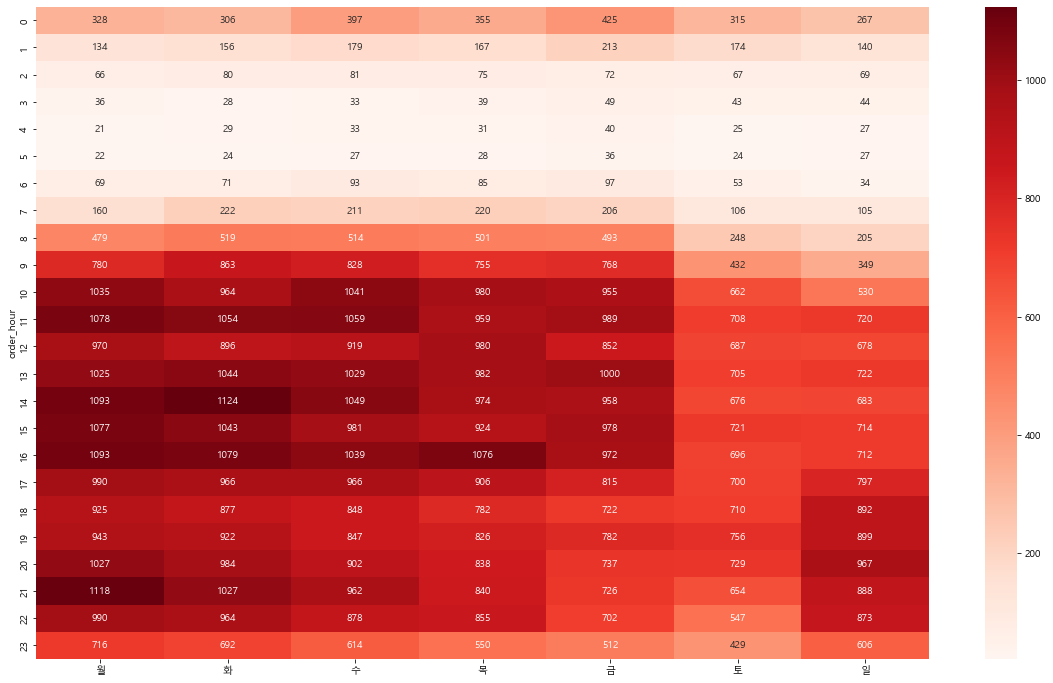

In [45]:
# 히트맵으로 표현해보기 
plt.figure(figsize = (20,12))
sns.heatmap(data = order_hour_dow,
            annot = True, 
            cmap = 'Reds', fmt = '.0f')

In [46]:
# heatmap의 장점은 전 컬럼 (월~일)에서 컬러의 농도가 배치되었다는 것. 
# 월요일 21시 / 화요일 14시 / 목요일 16시에 구매가 많이 발생함. 금요일부터 주문이 줄어듬 왜 일요일에는 안사는걸까? 왜 ? 
# 주말낀 배송때문에 그런걸까? 한국식 주말배송/ 샛별배송도입이 시급? 

# #분석 2. 구매에서 배송까지 평균 얼마나 걸리는지? 


In [47]:
od_valid.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2804,05b2ebbb3869fd116a0a1c247ba70d00,115f6268f9705c6ed3b4119c8fe5f85e,delivered,2017-05-17 11:07:52,2017-05-17 11:22:29,2017-05-19 10:22:53,2017-05-24 13:16:01,2017-06-21
29876,2c48969e48da7da20b6122d12778ea37,c87464756849e9ae28ff65d899ad809f,delivered,2018-07-06 00:22:39,2018-07-06 00:35:12,2018-07-10 21:16:00,2018-07-13 20:22:39,2018-07-25
85832,b2dddd3ac6945bfb4a4a8b336d830a64,547d7962c21b9a177226c430300019ab,delivered,2018-03-06 18:38:25,2018-03-06 18:49:34,2018-03-12 23:32:44,2018-04-04 22:19:12,2018-04-18
41462,84b9c4e0d6fa518c27bacb0b602b028c,d2821632217cab913420f7c8276bfc63,delivered,2018-03-13 16:23:13,2018-03-15 03:30:35,2018-03-15 18:11:14,2018-04-14 00:19:03,2018-04-10
80164,20e871f0177ed08afbde20c48b9ab83e,b8326a40ee0667ece0fa82835b3fe286,delivered,2018-06-24 09:58:26,2018-06-24 10:15:36,2018-06-25 14:13:00,2018-07-03 18:52:57,2018-07-23


각 컬럼들 정보 

- order_id : 주문번호 
- customer_id : 고객번호 - 근데 요거 path[0] 보면 customer_id는 구매시마다 새로 생기는 id임. customer_unique_id가 진짜 고객 번호 
- order_status : 주문상태
- order_purchase_timestamp : 주문일자 
- order_approved_at : 지불승인일자 (금융사 카드결제/ 통장입금확인되어 올리스트로 매출(고객입장에선 구매)이 잡히는 시간 같음
- order_delivered_carrier_date : 물류팀에 인도된 일자 (송장 나온날짜 같음)
- order_delivered_customer_date  : 배송완료일자(수령일자)
- order_estimated_delivery_date : 예상배송완료일자

In [48]:
# 가져올 컬럼 - 배송시작일자 , 구매일자 , 예상배송일자
# 컬럼명 변경해서 새로운 데이터 프레임에 담자 

In [49]:
# purchase to deliver (ptd)라는 변수에 담을거임 
ptd = od_valid[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
ptd.sample()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
71113,2017-02-22 17:12:07,2017-03-10 06:05:11,2017-03-30


In [50]:
# 컬럼명 변경해주기 
ptd.rename(columns = {'order_purchase_timestamp':'주문일자',
                      'order_delivered_customer_date':'배송완료일자', 
                      'order_estimated_delivery_date':'예상배송일자'}, inplace= True)
ptd

,주문일자,배송완료일자,예상배송일자
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18
1,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13
2,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04
3,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15
4,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26
...,...,...,...
99436,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28
99437,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02
99438,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27
99439,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15


In [51]:
# 주문일자와 배송완료일자컬럼 슬라이싱으로 년-월-일 만 남기기 
ptd['주문일자'] = ptd['주문일자'].astype(str).str[:10]
ptd['배송완료일자'] = ptd['배송완료일자'].astype(str).str[:10]

In [52]:
# str로 변경된 데이터 타입 다시 datetime으로 바꿔주기 그래야 날짜 연산이 됨 
ptd['주문일자'] = pd.to_datetime(ptd['주문일자'])
ptd['배송완료일자'] = pd.to_datetime(ptd['배송완료일자'])
ptd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99281 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   주문일자    99281 non-null  datetime64[ns]
 1   배송완료일자  96462 non-null  datetime64[ns]
 2   예상배송일자  99281 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 5.0 MB


In [53]:
# 배송에 걸린 기간
ptd['배송기간'] = ptd['배송완료일자'] - ptd['주문일자']
ptd

,주문일자,배송완료일자,예상배송일자,배송기간
0,2017-10-02,2017-10-10,2017-10-18,8 days
1,2018-07-24,2018-08-07,2018-08-13,14 days
2,2018-08-08,2018-08-17,2018-09-04,9 days
3,2017-11-18,2017-12-02,2017-12-15,14 days
4,2018-02-13,2018-02-16,2018-02-26,3 days
...,...,...,...,...
99436,2017-03-09,2017-03-17,2017-03-28,8 days
99437,2018-02-06,2018-02-28,2018-03-02,22 days
99438,2017-08-27,2017-09-21,2017-09-27,25 days
99439,2018-01-08,2018-01-25,2018-02-15,17 days


In [54]:
# 시각화를 위해 datetime 형태인 배송기간을 float 형태로 변환해 배송기간1로 지정 
ptd['배송기간1'] = ptd['배송기간'].dt.days
ptd

,주문일자,배송완료일자,예상배송일자,배송기간,배송기간1
0,2017-10-02,2017-10-10,2017-10-18,8 days,8.0
1,2018-07-24,2018-08-07,2018-08-13,14 days,14.0
2,2018-08-08,2018-08-17,2018-09-04,9 days,9.0
3,2017-11-18,2017-12-02,2017-12-15,14 days,14.0
4,2018-02-13,2018-02-16,2018-02-26,3 days,3.0
...,...,...,...,...,...
99436,2017-03-09,2017-03-17,2017-03-28,8 days,8.0
99437,2018-02-06,2018-02-28,2018-03-02,22 days,22.0
99438,2017-08-27,2017-09-21,2017-09-27,25 days,25.0
99439,2018-01-08,2018-01-25,2018-02-15,17 days,17.0


# #분석 2. 구매에서 배송까지 평균 얼마나 걸리는지? 

In [55]:
# 주문일로부터 배송기간 별(그룹바이...) 빈도수 
ptd.groupby(by = '배송기간1')['배송기간'].count()

배송기간1
0.0         1
1.0       629
2.0      2874
3.0      3448
4.0      4497
         ... 
194.0       1
195.0       2
196.0       1
208.0       1
210.0       1
Name: 배송기간, Length: 144, dtype: int64

<AxesSubplot:xlabel='배송기간1'>

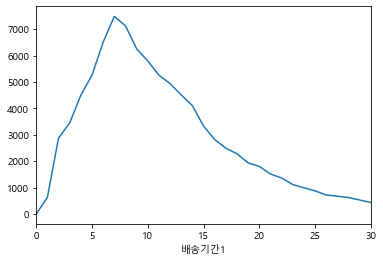

In [56]:
# 배송기간 별 빈도수 시각화 
plt.xlim(0,30)
ptd.groupby(by = '배송기간1').count()['배송기간'].plot()

In [57]:
ptd['배송기간1'].describe()

count    96462.000000
mean        12.497201
std          9.556095
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        210.000000
Name: 배송기간1, dtype: float64

In [58]:
# 구매후 배송완료까지 평균 12일 정도. 중간값 10일 정말 빠르면 7일 ... 

# #분석 3. 주문일자와 승인일자사이의 갭. 
- 2016년에 삼성페이가 도입되었는데도 왜 갭이 있는지? 브라질의 사회,문화적 풍습과 연관지어보기 
(2017~2018년도의 시계열 데이터)

In [59]:
# https://s-space.snu.ac.kr/bitstream/10371/97122/1/02.pdf
# 2016년에 브라질 대통령 탄핵 이슈 , 포퓰리즘. 국가부채 증가 

In [60]:
od_valid.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
52924,5f828ec3917806a1b1ca5c9008703f26,ccb458d4532723d02a5229c1b93cf98d,delivered,2018-04-08 17:03:29,2018-04-08 17:15:21,2018-04-09 22:27:27,2018-04-24 14:18:33,2018-05-10
13569,e077480e5c55c37d64833e295eab9b3b,d9ea749aa16d62d68ba87384a95091cc,delivered,2017-07-21 15:24:08,2017-07-21 16:05:34,2017-07-26 10:34:52,2017-07-28 18:22:39,2017-08-10
23042,c0a4f59b8df4e3d9d73bc2d28982fb1c,0acbcf4c99216f66aeb7c583bca57fb9,shipped,2018-04-26 14:39:40,2018-04-26 14:51:48,2018-04-27 09:35:00,NaT,2018-05-18
69764,758d844e553488d2af66539369ed624a,5bae4968446165fdd4dd2d6889769ce6,delivered,2017-03-30 08:50:15,2017-04-01 09:35:18,2017-04-03 15:07:57,2017-04-11 09:44:12,2017-04-24
69688,e257fe6c043babc3b737247f4f2a88c9,c18e8169eb0401dd69528d0706769028,delivered,2017-12-09 22:28:45,2017-12-09 22:37:22,2017-12-12 21:09:22,2017-12-18 21:09:58,2018-01-04


In [61]:
# 주문일자랑 지불승인일자 사이의 갭 구할거임 
date_gap = od_valid[['order_purchase_timestamp', 'order_approved_at']]
date_gap.sample()

,order_purchase_timestamp,order_approved_at
57048,2018-01-10 10:32:16,2018-01-10 10:49:29


In [62]:
# 컬럼명 변경해주기 
date_gap.rename(columns = {'order_purchase_timestamp':'주문일자',
                      'order_approved_at':'지불승인일자' }, inplace= True)
date_gap

,주문일자,지불승인일자
0,2017-10-02 10:56:33,2017-10-02 11:07:15
1,2018-07-24 20:41:37,2018-07-26 03:24:27
2,2018-08-08 08:38:49,2018-08-08 08:55:23
3,2017-11-18 19:28:06,2017-11-18 19:45:59
4,2018-02-13 21:18:39,2018-02-13 22:20:29
...,...,...
99436,2017-03-09 09:54:05,2017-03-09 09:54:05
99437,2018-02-06 12:58:58,2018-02-06 13:10:37
99438,2017-08-27 14:46:43,2017-08-27 15:04:16
99439,2018-01-08 21:28:27,2018-01-08 21:36:21


In [63]:
date_gap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99281 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   주문일자    99281 non-null  datetime64[ns]
 1   지불승인일자  99281 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 4.3 MB


In [64]:
# 주문일자랑 지불승인일자 연-월-일만 남기기 
date_gap['주문일자1'] = date_gap['주문일자'].astype(str).str[:10]
date_gap['지불승인일자1']= date_gap['지불승인일자'].astype(str).str[:10]
date_gap

,주문일자,지불승인일자,주문일자1,지불승인일자1
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-02,2017-10-02
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-24,2018-07-26
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08,2018-08-08
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-18,2017-11-18
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-13,2018-02-13
...,...,...,...,...
99436,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-09,2017-03-09
99437,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-06,2018-02-06
99438,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-27,2017-08-27
99439,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-08,2018-01-08


In [65]:
# str로 변경된 데이터 타입 다시 datetime으로 바꿔주기 그래야 날짜 연산이 됨 
date_gap['지불승인일자1'] = pd.to_datetime(date_gap['지불승인일자1'])
date_gap['주문일자1'] = pd.to_datetime(date_gap['주문일자1'])

In [66]:
# 승인 소요일자 계산
date_gap['승인소요일'] = date_gap['지불승인일자1'] - date_gap['주문일자1']
date_gap

,주문일자,지불승인일자,주문일자1,지불승인일자1,승인소요일
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-02,2017-10-02,0 days
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-24,2018-07-26,2 days
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08,2018-08-08,0 days
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-18,2017-11-18,0 days
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-13,2018-02-13,0 days
...,...,...,...,...,...
99436,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-09,2017-03-09,0 days
99437,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-06,2018-02-06,0 days
99438,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-27,2017-08-27,0 days
99439,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-08,2018-01-08,0 days


In [67]:
date_gap['승인소요일1'] = date_gap['승인소요일'].dt.days
date_gap.sample(3)

,주문일자,지불승인일자,주문일자1,지불승인일자1,승인소요일,승인소요일1
95036,2018-04-13 18:31:42,2018-04-13 18:52:12,2018-04-13,2018-04-13,0 days,0
9688,2017-12-26 16:41:55,2017-12-26 16:50:31,2017-12-26,2017-12-26,0 days,0
95643,2018-04-20 23:06:26,2018-04-24 17:46:08,2018-04-20,2018-04-24,4 days,4


In [68]:
date_gap['승인소요일1'].unique()
# 바로 결제하는사람들이랑 좀 이따 결제하는사람들이랑 얼마나 되는지 시각화 해보자 

array([  0,   2,   5,   1,   4,   3,   6,  11,  32,  33,   8,   7,  12,
        24,  13,  10, 188,  29,   9,  31,  60,  17,  23], dtype=int64)

In [69]:
# 주문일로부터 승인소요일 별 (그룹바이...) 빈도수 
date_gap.groupby(by = '승인소요일1')['승인소요일'].count()

승인소요일1
0      68731
1      17187
2       9175
3       2269
4       1352
5        408
6         60
7         28
8         16
9          6
10         6
11        13
12        13
13         5
17         1
23         2
24         1
29         1
31         2
32         1
33         2
60         1
188        1
Name: 승인소요일, dtype: int64

<AxesSubplot:xlabel='승인소요일1'>

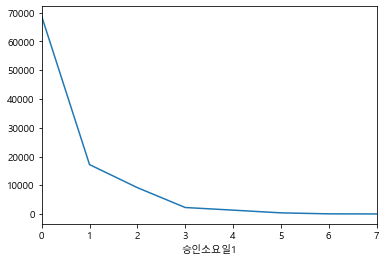

In [70]:
# 빈도수 시각화 
plt.xlim(0,7)
date_gap.groupby(by = '승인소요일1')['승인소요일'].count().plot()

In [71]:
# 일반적으로 당일 승인이 대부분이지만 1,2일 소요 되는 사람들도 있다 -> 이 사람들은 지불수단이 입금인걸까? 확인해보기 

# #분석 4. 배송은 완료됬는데 수령일자가 없다?
-> status : delivered,  delivered_Customer_Date -> Null
오배송 혹은 분실률 통해서 고객 이탈률...

In [72]:
od.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
43512,f2228e3e55ff956909ad7750f08516fd,fb60e1236b474808fc33b9d2bf26d323,delivered,2018-04-01 11:17:22,2018-04-01 11:30:17,2018-04-04 00:47:20,2018-04-11 18:52:20,2018-04-25


In [73]:
# 배송완료여부가 null(배송아직안됨)인 컬럼들 조건 걸어서 새로운 데이터프레임 생성 
deliver_process = od.loc[od['order_delivered_customer_date'].isnull()]
deliver_process.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5328,84cee5c1b66cfc2dcb7c7834e7169246,11dda77241f7f71d51f1c55688fd1c62,shipped,2017-03-08 17:42:59,2017-03-08 17:42:59,2017-03-09 10:34:11,NaT,2017-04-06
2492,02ea547b6d2ee25305588fd50df58b46,ff4545a3148f5a22667f301e00cb5ad7,shipped,2017-03-23 22:03:43,2017-03-23 22:10:24,2017-03-28 11:43:01,NaT,2017-04-18
69213,ee554cb464769c4696df94a049fa792f,75b28a861ab167c1271f55c3cb362d1d,shipped,2017-11-29 15:16:26,2017-11-29 15:42:48,2017-11-30 20:32:01,NaT,2017-12-27
74425,94b85615d0bf9757c6a3b1a20be1a9cf,5738d0a3932e3ae32a2169b9040e5c0b,shipped,2018-05-14 09:17:04,2018-05-14 09:32:25,2018-05-17 14:11:00,NaT,2018-06-04
94832,23e0d289631ee7c7e4503aa7a8a32c15,d6815b79026dc1c07be2648bad010e80,shipped,2018-03-19 20:09:17,2018-03-21 02:56:05,2018-03-23 15:42:42,NaT,2018-04-09


In [74]:
# shipped 배송중 
# 주문완료된 후 배송상태가 여러개임 
deliver_process['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [75]:
# 배송일자도 없는데 주문상태에 배송완료라고 뜸 
deliver_null = deliver_process.loc[deliver_process['order_status'].str.contains('delivered')]
deliver_null

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [76]:
deliver_null.count()
# 8개 정도가 분실 되었을 가능성 있음 

order_id                         8
customer_id                      8
order_status                     8
order_purchase_timestamp         8
order_approved_at                8
order_delivered_carrier_date     7
order_delivered_customer_date    0
order_estimated_delivery_date    8
dtype: int64